In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

In [3]:
# Import train and test set

df_train = pd.read_csv('../raw_data/aug_train.csv')
df_test = pd.read_csv('../raw_data/aug_test.csv')
print(df_train.shape, df_test.shape)

(19158, 14) (2129, 13)


# I. Data Wrangling

In [4]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [5]:
df_train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [6]:
# Create list of ids that belong to each df

test_id = df_test.enrollee_id.values.tolist()
train_id = df_test.enrollee_id.values.tolist()

In [7]:
# Merge train and test for cleaning
df = df_train.merge(df_test, how='outer', on=['enrollee_id', 'city', 'city_development_index', 'gender', 
                                              'relevent_experience', 'enrolled_university', 'education_level',
                                              'major_discipline', 'experience', 'company_size', 'company_type',
                                              'last_new_job', 'training_hours'])
df.shape

(21287, 14)

In [8]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


#### a) Change columns to correct dtype

In [37]:
df.dtypes

enrollee_id                object
city                       object
city_development_index    float64
gender                     object
relevent_experience         int32
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [19]:
# Convert enrollee_id to string
df['enrollee_id'] = df['enrollee_id'].astype(str)

In [17]:
df['relevent_experience'].value_counts()

Has relevent experience    15316
No relevent experience      5971
Name: relevent_experience, dtype: int64

In [21]:
# Change relevant experience to binary values
df['relevent_experience'] = np.where(df['relevent_experience']=='Has relevent experience', 1, 0)

In [30]:
df['experience'].value_counts()

>20    3669
5      1593
4      1548
3      1508
6      1346
2      1255
7      1144
9      1093
10     1081
8       884
11      750
15      745
14      641
1       605
<1      596
16      576
12      546
13      453
17      378
19      333
18      306
20      167
Name: experience, dtype: int64

In [31]:
df['company_size'].value_counts()

50-99        3421
100-500      2889
10000+       2236
10/49        1643
<10          1471
1000-4999    1471
500-999       965
5000-9999     631
Name: company_size, dtype: int64

In [33]:
df['last_new_job'].value_counts()

1        8924
>4       3643
2        3242
never    2710
3        1157
4        1148
Name: last_new_job, dtype: int64

In [109]:
# Cols that will need to be ordinally encoded
ord_cols = ['experience', 'company_size', 'last_new_job']

# Cols that will need to be one-hot encoded
cat_cols = ['enrolled_university', 'education_level', 'major_discipline']

# II. Preprocessing

In [132]:
KNN_imputer = KNNImputer(n_neighbors=22)

df['experience'] = KNN_imputer.fit_transform(df['experience'])
df['experience'].head()

ValueError: could not convert string to float: '>20'

In [124]:
# Ordinal encoding
enc_ord = OrdinalEncoder()
df[ord_cols] = enc_ord.fit_transform(df[ord_cols])
df[ord_cols].head()

ValueError: Input contains NaN

In [36]:
df.describe()

,city_development_index,relevent_experience,training_hours,target
count,21287.000000,21287.000000,21287.000000,19158.000000
mean,0.828462,0.719500,65.328510,0.249348
std,0.123537,0.449254,60.075201,0.432647
min,0.448000,0.000000,1.000000,0.000000
25%,0.739000,0.000000,23.000000,0.000000
50%,0.903000,1.000000,47.000000,0.000000
75%,0.920000,1.000000,88.000000,0.000000
max,0.949000,1.000000,336.000000,1.000000


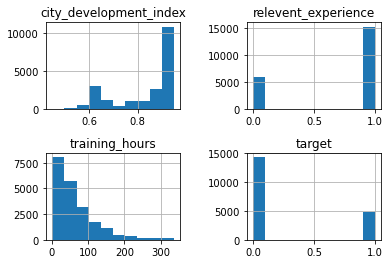

In [42]:
df.hist();
plt.subplots_adjust(hspace=.5, wspace=.5);

In [110]:
for i, col in enumerate(cat_cols):
    print(i,col)

0 enrolled_university
1 education_level
2 major_discipline


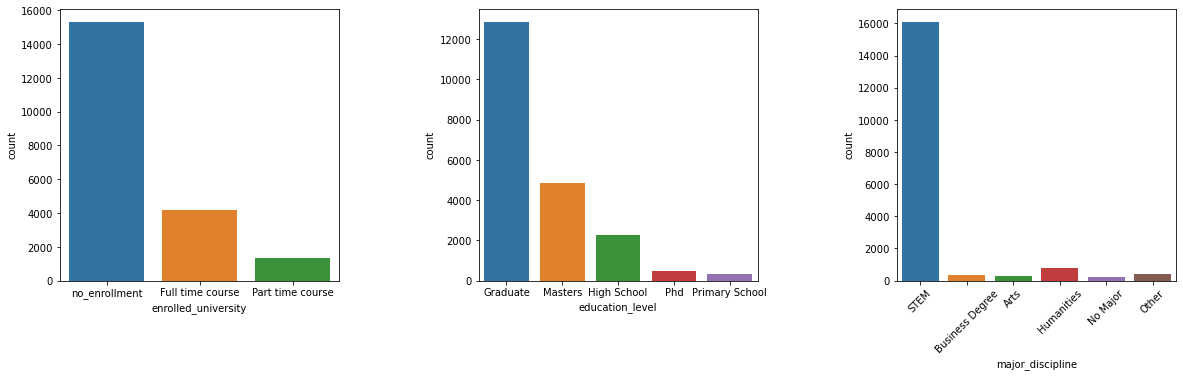

In [122]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
fig.subplots_adjust(wspace=0.5, hspace=0.5);
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=ax[i])
    plt.xticks(rotation=45)

In [64]:
# Number of NAs in each column

df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    5016
relevent_experience          0
enrolled_university        417
education_level            512
major_discipline          3125
experience                  70
company_size              6560
company_type              6774
last_new_job               463
training_hours               0
target                    2129
dtype: int64